<a href="https://colab.research.google.com/github/paulodowd/Webots_2021/blob/master/WLabsheets/L4_ObstacleAvoidance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Labsheet 4: Obstacle Avoidance

In previous labsheets we have investigated:
- making the robot move.
- bang-bang control.
- weighted-sensing for line following.
- proportional control.
- Finite State Machines, transitioning between states or robot behaviours.

In this labsheet, we will investigate the new required behaviour Obstacle Avoidance.  This labsheet provides exercises to develop a `reactive` obstacle avoidance controller.  This means that the obstacle avoidance behaviour is created through an immediate response to sensor stimuli, with no memory or planning algorithmically specified.  

The principle approach to this obstacle avoidance solution is inspired by Chapter 2 Evolutionary and Neural Techniques from the book:
> Nofli, S. and Floreano, D. (2001) _Evolutionary Robotics: The Biology, Intelligence and Technology of Self-organizing Machines._  MIT Press.  



<hr><br><br><br><br>

## E-Puck Proximity Sensors

Within the provided Webots world file, your simulated robot should meet an obstruction along the line following map.  This obstruction is a pink block.  The exact location of the pink block is not critical, however it should be investigated by you for the challenge is presents:

<p align="center">
<img src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_Obstruction.png?raw=true">
</p>

Your simulated robot is required to detect this block and safely navigate around it, to rejoin the line and continue line following.  To achieve this functionality, we will use the proximity sensors of the e-puck robot.

The simulated e-puck robot has 8 infra-red proximity sensors, positioned around the robot body.  These sensors are enumerated (indexed) following the same scheme in the below diagram (`ps0` ... `ps7`, "proximity sensor"):

<p align="center">
<img src="https://raw.githubusercontent.com/cyberbotics/webots/released/docs/guide/images/robots/epuck/sensors_and_leds.png">
</p>

Similar to the ground sensor, the proximity sensor transmits a beam of infra-red light and measures the intensity of the reflection.  These sensors have been modelled in Webots to have the following **`sensor response`**:

<p align="center">
<img width="75%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_EpuckProxResponse.png?raw=true">
</p>

In the above plot from the <a href="https://cyberbotics.com/doc/guide/epuck#e-puck-model">Webots documentation</a>, we can observe:
- the sensor response is `non-linear`.
- the sensor response is `high` at `close proximity`.
- the sensor response is `low` at `far proximity`.
- the maximum range of the sensor is 7cm.
- the measured signal flattens out at a value of approximately `34`, an offset bias.
- there is some noise in the measurement signal.

## Exercise 1: E-Puck Model

1. If the maximum raw measurement from the `analog-to-digital` converter (ADC) is 4095, how many bits of resolution must the ADC be configured to?

2. Would you regard this sensor as:
  - `precise`?
  - `accurate`?


3. **Validate**: Use the Webots simulator and write a simple program to report the readings from the proximity sensors.  Use the below code cell to plot your results with respect to distance.  Does the sensor in Webots perform the same as the graph provided above from the documentation?
  - It is easiest to report readings from just one sensor, such as `ps0` or `ps2`.
  - You can use the left-hand panel in Webots to set the exact starting position of both the robot and an obstacle.  To identify an obstacle, click the obstacle and then look for the highlighted field in the left-hand pane.

<p align="center">
<img src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_SettingObstacle.png?raw=true">
</p>

4. The shape of the `sensor response` is `non-linear`, and this has implications for the robot's ability to perceive the environment:
  - What is the useful range of this sensor?
  - At what distance, or what reading value, do the sensors become not useful?





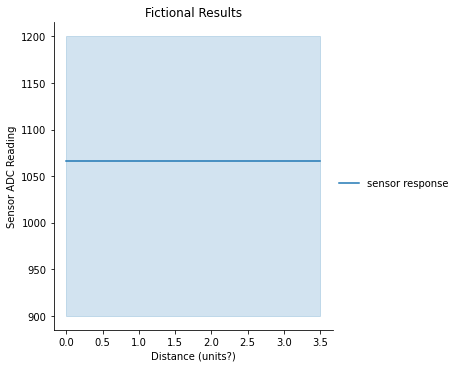

In [ ]:
#
# An example of using Python, Seaborn and
# Pandas to plot data into a line plot with
# the region of error around the line.

# We use numpy to create an array of values
# Panda dataframes want arrays not lists.
import numpy as np

# We will use a library called Seaborn to
# make our plot for us, so we import it.
import seaborn as sns

# We need to format the
# data into 'dataframes'.  We use the pandas
# library to do this for us.  Import pandas:
import pandas as pd

# Add your measurements into the array
# like the following.
# This allows multiple data entries per
# point on the x axis.
# Columns as:
# [ <distance>, <measurement> ]
results = np.array(
[ [0, 1100],
  [0, 1200],
  [0, 900],
  [0.5, 1100],
  [0.5, 1200],
  [0.5, 900],
  [1, 1100],
  [1, 1200],
  [1, 900],
  [1.5, 1100],
  [1.5, 1200],
  [1.5, 900],
  [2, 1100],
  [2, 1200],
  [2, 900],
  [2.5, 1100],
  [2.5, 1200],
  [2.5, 900],
  [3, 1100],
  [3, 1200],
  [3, 900],
  [3.5, 1100],
  [3.5, 1200],
  [3.5, 900] # etc
 ] )

# Reformat the data using pandas
results = {"sensor response": pd.Series(results[:,1], index=results[:,0]) }

dataframe = pd.DataFrame( results );


# We can now plot both datasets at the same time.
# Note, data=combined!
plot = sns.relplot(data=dataframe, kind="line")
plot.set(xlabel ="Distance (units?)", ylabel = "Sensor ADC Reading", title ='Fictional Results')

<hr><br><br><br><br>

# Obstacle Avoidance Behaviour

When developing Obstacle Avoidance behaviour, it is recommended to put aside any previous line following behaviour.  It is better to simplify the problem first.  Once obstacle avoidance is achieved, the complexity of the problem can be increased to include line following behaviour.  

<p align="center">
<img width="50%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_ObsAvoid.png?raw=true">
</p>

For obstacle avoidance behaviour, it is necessary for the robot to decide:
- is there an obstruction?
  - a logical choice, similar to the bang-bang controller operation.
- how to utilise the 8 sensors?
  - a more complex issue, where a form of weighted-measurement might be useful.

In Labsheet 2 we implemented a `weighted-measurement` for line following.  This was expressed as the equations:

<p align="center">
$w_{left} = ( gs_{0} + ( gs_{1} * 0.5 ) )$
</p>
<p align="center">
$w_{right} = ( gs_{2} + ( gs_{1} * 0.5 ) )$
</p>

<p align="center">
$e_{line} = w_{left} - w_{right}$
</p>

where `gs0`, `gs1`, and `gs2` correspond to the left, centre and right sensing elements of the ground sensor.  In the above equations, we can see that the value of `gs1` is weighted by 0.5.  

As a matter of interest, we can also reconceptualise this technique with an illustration of the form of a very simple <a href="https://en.wikipedia.org/wiki/Artificial_neural_network">artificial neural network</a>, where each node in the network transferring forward a summation weighted inputs:

<p align="center">
<img width="50%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_LineANN.png?raw=true">
</p>

In the above illustration, the value from each node is fed forwards, as indicated by the arrows.  So in the first row of nodes ("input layer"), the nodes labelled `gs0`, `gs1`, `gs21` receive the latest value of the ground sensors.  The small numbers next to the arrows represent `weights`.  When a weight has magnitude `1.0`, the value passed forwards is unmodified.  When a weight has magnitude `0.0`, this would effectively negate the propogation of the input to the next connected node.  Each node in the network operates a simple summation of all the inputs received as a `transfer function`.

This representation of weighting inputs to produce a useful output is particularly useful for designing obstacle avoidance.  In the case of the e-puck robot, there are 8 infra-red proximity sensors, and we must decide how they can be used to effect obstacle avoidance behaviour.

<p align="center">
<img width="75%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_ObsANN.png?raw=true">
</p>

In the above illustration, it is necessary to decide which sensors (`ps0` to `ps7`) will be fed forwards to the output node, $e_{obs}$ (error - obstruction), and with what weighting.  Here, we are assuming a similar principle of operation to our prior work in Labsheet 2 Line Sensing, where $e_{obs}$ would be an error signal used to then inform the operation of both left and right motors.

<p align="center">
<img src="https://raw.githubusercontent.com/cyberbotics/webots/released/docs/guide/images/robots/epuck/sensors_and_leds.png">
</p>

If we consider the above body-plan of the e-puck robot, we can see that `ps7` and `ps0` face directly forwards.  We can imagine that encountering an obstruction on these sensors would cause a rapid turn.  Furthermore, for `ps7`, the robot might need to turn right, and for `ps0` the robot might need to turn left.  


Within Webots, we can access the e-puck proximity sensors with the following example code extract:

```c

  // Loop through all proximity sensors [0:7]
  int i;
  for( i = 0; i < NB_PS; i++ ) {

    // read value from sensor
    ps_value[i] =  wb_distance_sensor_get_value(ps[i]);
    
    // Print this value to the console to inspect.
    printf("%f,", ps_value[i]);
  }
  printf("\n");
```

The following code extract illustrates how `weights` could be used to generate an output signal, $e_{obs}$:

```c
int i;
// Same number of weigths as sensors
float weights[NB_PS] = { 0.1, 0.2, 0.4, 0.5, -0.5, -0.4, -0.2, -0.1 };
float e_obs;

// Set initial value.
e_obs = 0.0;
for( i = 0; i < NB_PS; i++ ) {

    // read value from sensor
    ps_value[i] =  wb_distance_sensor_get_value(ps[i]);

    // Simple summation of weighted sensor values.
    e_obs = e_obs + ( ps_value[i] * weights[i] );

}

```

It is possible to configure a variety of connections between the sensors and some output node(s).  It is also possible to design a very simple ANN to utilise two output nodes, one to control the left motor speed and one to control the right motor speed:

<p align="center">
<img width="50%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_ObsANN_2.png?raw=true">
</p>

## Exercise 2: Obstacle Avoidance

Depending on your implementation you could either:
 - have obstacle avoidance always active, but not not always contributing to motion (e.g., in the ANN implementation above, it is possible to have a configuration of the network that provides 0 contribution when no sensors are active).
 - have obstacle avoidance activated only when necessary.  In this method, you would need to add a simple check on your proximity sensors to decide whether obstacle avoidance is necessary.


1. Before you start writing code consider:
  - how could obstacle avoidance behaviour be achieved with a bang-bang controller?
  - what advantages or disadvantages might there to a bang-bang controller?

2. Decide a threshold value from the `sensor response curve` for when an `obstacle avoidance behaviour` should be activated.  
  - **Note:** the proximity sensors always report a value, even when there is not an obstruction.
  - write a function to check all proximity sensors and return an appropriate value if obstacle avoidance is required.
  - check that this function operates reliably.
  - utilise the result of this function to either:
    - transition your FSM into/out-of obstacle avoidance appropriately (preferred)
    - activate obstacle avoidance execution flow in your program

3. Start by creating a weight of 0 for all sensors.  With just the two foward proximity sensors, find weight values to effect a turning behaviour in the approriate direction:
  - which two proximity senors are the most forward facing?
  - how might you pre-process your proximity sensor measurements to make subsequent calculations easier?
  - **help:** to begin with, do not have your robot move forward or backward, only turn on the spot.  
  - **help:** remember that you can position your robot within the environment by clicking on it.
  - **help:** avoid **`blocking code`** - for exmaple, your obstacle avoidance function should return and be called again by `loop()` even while there is an obstruction.
  - what would be a desirable value of `e_obs` if both forward sensors report identical values, or cancel each other out?  Implement a bias in your gain values to solve this issue.  
    - **Hypothesise:** in what environment circumstances would the robot be in where both sensors report the same value?
  - **Validate:** using just the two forward sensors, how far does your robot rotate away from the obstruction?  Would this enough to transit without collision?
  - **help**: the following code extract follows a similar format to line following:


  ```c

void loop() {

  

  // Get the line error
  float e_obs;
  e_obs = getObstacleError();

  // Determine a proportional rotation speed
  float turn_velocity;
  turn_velocity = ????;  // What is a sensible maximum speed?
  turn_velocty = turn_velocity * e_obs;

  // Set motor values.
  // What does "0 -" and "0 +" achieve here?
  wb_motor_set_velocity(right_motor, 0 - turn_velocity);
  wb_motor_set_velocity(left_motor, 0 + turn_velocity);
  
}

// A function to return an error signal representative
// of the line placement under the ground sensor.
float getObstacleError() {
  float weights[NB_PS] = { 0.1, 0.2, 0.4, 0.5, -0.5, -0.4, -0.2, -0.1 };
  float e_obs;

  // Read proximity sensors, store result

  // Calculated error signal
  e_obs = ????;

  // Return result
  return e_obs;
}

```

3. Progressively implement the remaining proximity sensors into your obstacle avoidance function:
  - are all sensors necessary?
  - two sensors are at the rear of the robot, are these useful?

4. Implement a forward velocity for your obstacle avoidance:
  - consider if this can be `proportionally controlled`, and whether this is useful.  What would be a useful measurement for forward velocity control?
  - when would a backward velocity useful?

5. How might you calculate a measure of obstacle avoidance performance?
  - what `proprioceptive` information is available to the robot?
  - what `exteroceptive` information is available to the robot?
  - what features of the robot behaviour are more or less desirable, and how could these be represented mathematically within this `metric` of performance?
  - how could this `metric` be defined and calculated to make it as transferable (comparable) as possible between different robotic systems?
  - **help**: in machine learning, we might consider this the <a href="https://en.wikipedia.org/wiki/Reinforcement_learning">reward function</a> or the <a href="https://en.wikipedia.org/wiki/Evolutionary_algorithm">fitness function</a>.  
  



<hr><br><br><br><br>

## Exercise 3: Obstacle Tracking

In this exercise we will investigate a method to process the proximity sensors on the robot to be more intuitive to use.  Currently, the sensors have a non-linear response.  In this exercise, we will look at signal conditioning to make the sensor response linear.  

<p align="center">
<img width="75%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_ObsTracking.png?raw=true">
</p>

Within the Line Following Challenge it is necessary that your robot can avoid the obstruction on the line but continue to follow the line afterwards.  To produce this behaviour it is necessary that your robot does not simply avoid the obstacle, but circumnavigates the perimeter of the obstacle.

<p align="center">
<img width="75%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_ObsConditioning.png?raw=true">
</p>

We can review the plot of the sensor response you have produced earlier in the labsheet.  The above plot is from the Webots documentation, your's should look similar.  When we consider the response of the sensor, we can identy three important characteristics:

- In the above, the red area represents when the robot is getting **too close** to an obstruction, and would need to make an avoidance motion.  
- In the above, the green area represents when the robot is **moving away** from the obstruction.  To keep the obstruction within the sensor detection, this range of the sensor could be used to provide an attraction motion towards the obstruction.
- Between these two ranges is an **ideal** distance, which needs to be determined to stop the robot from colliding with an obstruction, but not losing the obstruction.  

Using the idea of signal conditioning and a normalised value, we can represent the above intended responses in the range [-1.0 : +1.0 ], where `-1` would influence a maximally avoidant motion, and `+1` a maximally attractive motion.  Importantly, values less than `-1` or more than `+1` represent values we are not confident in, and so discard.  

<p align="center">
<img width="50%" src="https://github.com/paulodowd/Webots_2021/blob/master/images/Webots_ProxProcessed.png?raw=true">
</p>

We can consider this normalisation per sensor with respect to the robot, as illustrated above.


When we review the above plot, it has also been annotated in blue with the minimum and maximum of the sensor reading we are interested in, and the mid-point.  It is important to see that for a linear mapping, the mid-point of the range does not match the mid-point of our desired normalisation (a value of 0).  This is because the sensor has a non-linear reponse.

We can either make the normalisation a non-linear mapping, or we can first of all convert the sensor reading into a linear mapping of distance.  In these exercises, we decide to convert the sensor reading values into a linear mapping of distance:

1. Using the proximity sensor data with respect to distance that you have collected earlier, find an equation for a trend-line of best fit.  For the Webot e-puck proximity sensor, a simple power regression should be sufficient.
  - **Help:** If you are not sure how to do this, a quick method is to plot your data in Microsoft Excel, use the trendline function and enable the `display equation on chart` option.
  - **Help:** A power regression has the form:

> $ y = ax^{\beta}$

Here, $y$ is our sensor reading, and $x$ is the distance.  This equation can be re-arranged for $x$:

> $x = (y / a ) ^{1/\beta}$

2. Write a short function in your code to receive a sensor reading and return a distance value.
  - **Validate**: check that your robot returns an estimate of distance from an obstruction by setting up the simulator environment and reporting values to the console.

3. Determine an equation to take any distance estimate from a proximity sensor reading and normalise it between the values [ -1.0 : +1.0 ].   You will need to:
  - decide which distance values are the minimum and maximum points for your range.
  - calculate the total range of an expected reading from the sensor
  - include any offset of the total range of expected readings from zero
  - include an offset to center the normalisation (0) and provide -1.0/+1.0 output.
  - use this equation to create a new function in your code that will return this sensor reading normalisation.

4. **Validate:** Check that your normalisation is working as you'd expect.  Keep things simple to begin with.  Write some test code to report the normalised value under **controlled** conditions.  Keep your robot still, and experiment with the proximity of an obstruction.  
  - Check that your sensor reports a range [ -1.0 : +1.0 ].
  - At what distance does the normalisation report a 0 value?

5. **Validate:** Begin to integrate this new information into your obstacle avoiance controller.  Keep things simple to being with.  First of all, use the forward facing sensors and see if you can adjust your obstacle avoidance code so that your robot will move towards the obstruction but stop at the normalised value of 0.

6. **Validate:** Experiment with your obstacle avoidance controller across all sensors.  






<hr><br><br><br><br>